In [41]:
import os.path
import pickle
import random

from wbtools.lib.nlp.text_preprocessing import get_documents_from_text
from sentence_transformers import SentenceTransformer, util
from matplotlib import pyplot as plt
import numpy as np
import random
import umap
from scipy import spatial

import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from numpy import savetxt

## Define constants

In [42]:
min_sentence_length = 50
max_corpus_size = 10000
use_cached_embeddings = False
bio_sent_vec_model_location = "../biosentvec/model.bin"

## Read positive and negative sentences from file

In [43]:
def read_sentences_from_file(filepath, min_sent_length=20):
    return [sentence for line in open(filepath) for sentence in get_documents_from_text(
        text=line.strip(), split_sentences=True) if len(sentence) > min_sent_length]

sent_expr_pattern = read_sentences_from_file("../extracted_sentences/sentences_exp_pattern.txt",
                                                      min_sentence_length)
sent_subcellloc = read_sentences_from_file("../extracted_sentences/sentences_exp_subcellloc.txt",
                                                    min_sentence_length)
neg_sent_otherexpr = [sent for sent in open("../extracted_sentences/neg_sentences_otherexpr.txt") if len(sent) >
                      min_sentence_length]

## Clean sentences

In [44]:
def clean_sentences(sentences):
    stop_words = set(stopwords.words('english'))
    ret_sent = []
    for sentence in sentences:
        sentence = sentence.replace('/', ' / ')
        sentence = sentence.replace('.-', ' .- ')
        sentence = sentence.replace('.', ' . ')
        sentence = sentence.replace('\'', ' \' ')
        tokens = [token for token in word_tokenize(sentence) if token not in punctuation]
        sentence = ' '.join(tokens)
        ret_sent.append(sentence)
    return list(set([sent.strip(' ').strip('.;,/-|').strip() for sent in ret_sent]))

sent_expr_pattern_clean = clean_sentences(sent_expr_pattern)
sent_subcellloc_clean = clean_sentences(sent_subcellloc)
neg_sent_otherxpr_clean = clean_sentences(neg_sent_otherexpr)

## Sample sentences

In [45]:
def get_random_sentence_subset(sentences, max_num_sentences):
    corpus = sentences
    random.shuffle(corpus)
    return corpus[0:max_num_sentences]

if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_expr_pattern.txt") and os.path.exists("../sentence_embeddings/corpus_subcellloc.txt") and os.path.exists("../sentence_embeddings/corpus_neg_otherexpr.txt"):
    corpus_expr_pattern = [line.strip() for line in open("../sentence_embeddings/corpus_expr_pattern.txt")]
    corpus_expr_subcellloc = [line.strip() for line in open("../sentence_embeddings/corpus_subcellloc.txt")]
    corpus_neg_otherexpr = [line.strip() for line in open("../sentence_embeddings/corpus_neg_otherexpr.txt")]
else:
    corpus_expr_pattern = get_random_sentence_subset(sent_expr_pattern_clean, max_corpus_size)
    corpus_expr_subcellloc = get_random_sentence_subset(sent_subcellloc_clean, max_corpus_size)
    corpus_neg_otherexpr = get_random_sentence_subset(neg_sent_otherxpr_clean, max_corpus_size)
    with open("../sentence_embeddings/corpus_expr_pattern.txt", "w") as corpus_expr_pattern_file:
        for sent in corpus_expr_pattern:
            corpus_expr_pattern_file.write(sent + "\n")
    with open("../sentence_embeddings/corpus_subcellloc.txt", "w") as corpus_expr_subcellloc_file:
        for sent in corpus_expr_subcellloc:
            corpus_expr_subcellloc_file.write(sent + "\n")
    with open("../sentence_embeddings/corpus_neg_otherexpr.txt", "w") as corpus_neg_otherexpr_file:
        for sent in corpus_neg_otherexpr:
            corpus_neg_otherexpr_file.write(sent + "\n")

## Extract sentence embeddings with SBERT

In [46]:
if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_subcellloc.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle"):
    corpus_embeddings_expr_pattern = pickle.load(open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "rb"))
    corpus_embeddings_subcellloc = pickle.load(open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "rb"))
    corpus_embeddings_neg_otherexpr = pickle.load(open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "rb"))
else:
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    corpus_embeddings_expr_pattern = embedder.encode(corpus_expr_pattern, convert_to_tensor=True)
    corpus_embeddings_subcellloc = embedder.encode(corpus_expr_subcellloc, convert_to_tensor=True)
    corpus_embeddings_neg_otherexpr = embedder.encode(corpus_neg_otherexpr, convert_to_tensor=True)
    pickle.dump(corpus_embeddings_expr_pattern, open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "wb"))
    pickle.dump(corpus_embeddings_subcellloc, open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "wb"))
    pickle.dump(corpus_embeddings_neg_otherexpr, open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "wb"))

## Use UMAP to obtain a dataset that can be visualized in 2d

In [47]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_pattern_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern)
corpus_embeddings_subcellloc_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc)
corpus_embeddings_neg_otherexpr_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr)

In [48]:
colors = ['g'] * len(corpus_embeddings_expr_pattern_2d) + ['y'] * len(corpus_embeddings_subcellloc_2d) + ['b'] * len(corpus_embeddings_neg_otherexpr_2d)

In [49]:
all_corpora_2d = np.vstack((corpus_embeddings_expr_pattern_2d, corpus_embeddings_subcellloc_2d, corpus_embeddings_neg_otherexpr_2d))

## UMAP visualization with different colors for each sentence category
- expr_pattern = green
- subcellloc = yellow
- negative = blue

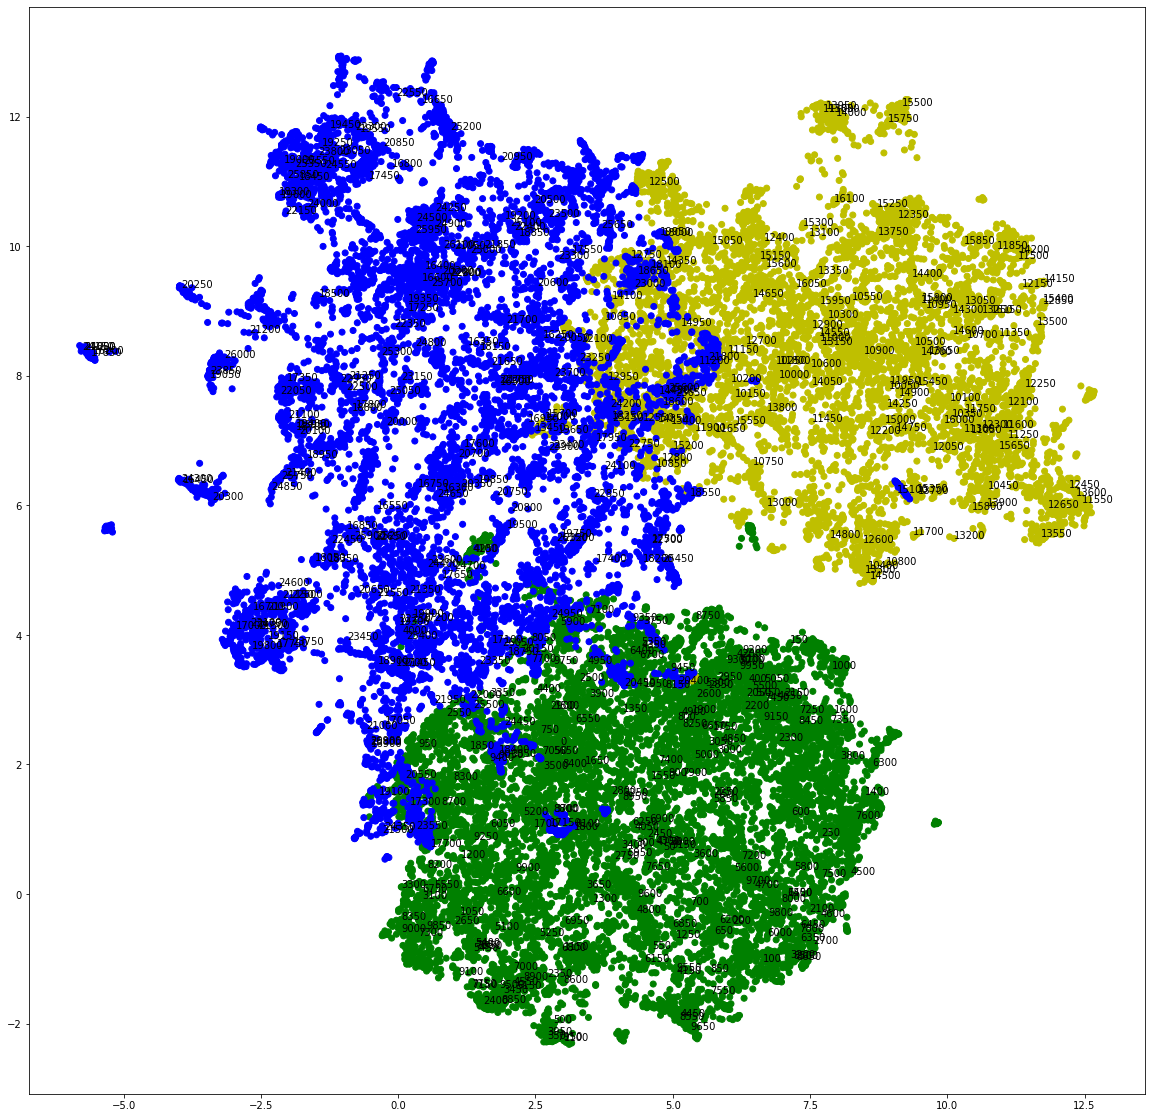

In [50]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_2d[:,0]), y=list(all_corpora_2d[:,1]), c=colors)
for i in range(len(all_corpora_2d)):
    if i % 50 == 0:
        plt.annotate(str(i), (all_corpora_2d[i,0], all_corpora_2d[i,1]))

In [51]:
best_matches = util.semantic_search(query_embeddings=corpus_embeddings_neg_otherexpr, corpus_embeddings=corpus_embeddings_expr_pattern)

In [52]:
[(i, corpus_id_score_dict) for i, values in enumerate(best_matches) for corpus_id_score_dict in values if corpus_id_score_dict['score'] > 0.8]

[]

In [53]:
1 - spatial.distance.cosine(corpus_embeddings_neg_otherexpr[394], corpus_embeddings_expr_pattern[2208])

0.10134502500295639

# Extract sentence embeddings with BioSentVec

In [54]:
model_path = bio_sent_vec_model_location
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [55]:
corpus_embeddings_expr_pattern_bio = biosentvec_model.embed_sentences(corpus_expr_pattern)
corpus_embeddings_subcellloc_bio = biosentvec_model.embed_sentences(corpus_expr_subcellloc)
corpus_embeddings_neg_otherexpr_bio = biosentvec_model.embed_sentences(corpus_neg_otherexpr)

In [56]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_pattern_bio_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern_bio)
corpus_embeddings_subcellloc_bio_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc_bio)
corpus_embeddings_neg_otherexpr_bio_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr_bio)

In [57]:
all_corpora_bio_2d = np.vstack((corpus_embeddings_expr_pattern_bio_2d, corpus_embeddings_subcellloc_bio_2d, corpus_embeddings_neg_otherexpr_bio_2d))

## UMAP visualization
- expr_pattern = green
- subcellloc = yellow
- negative = blue

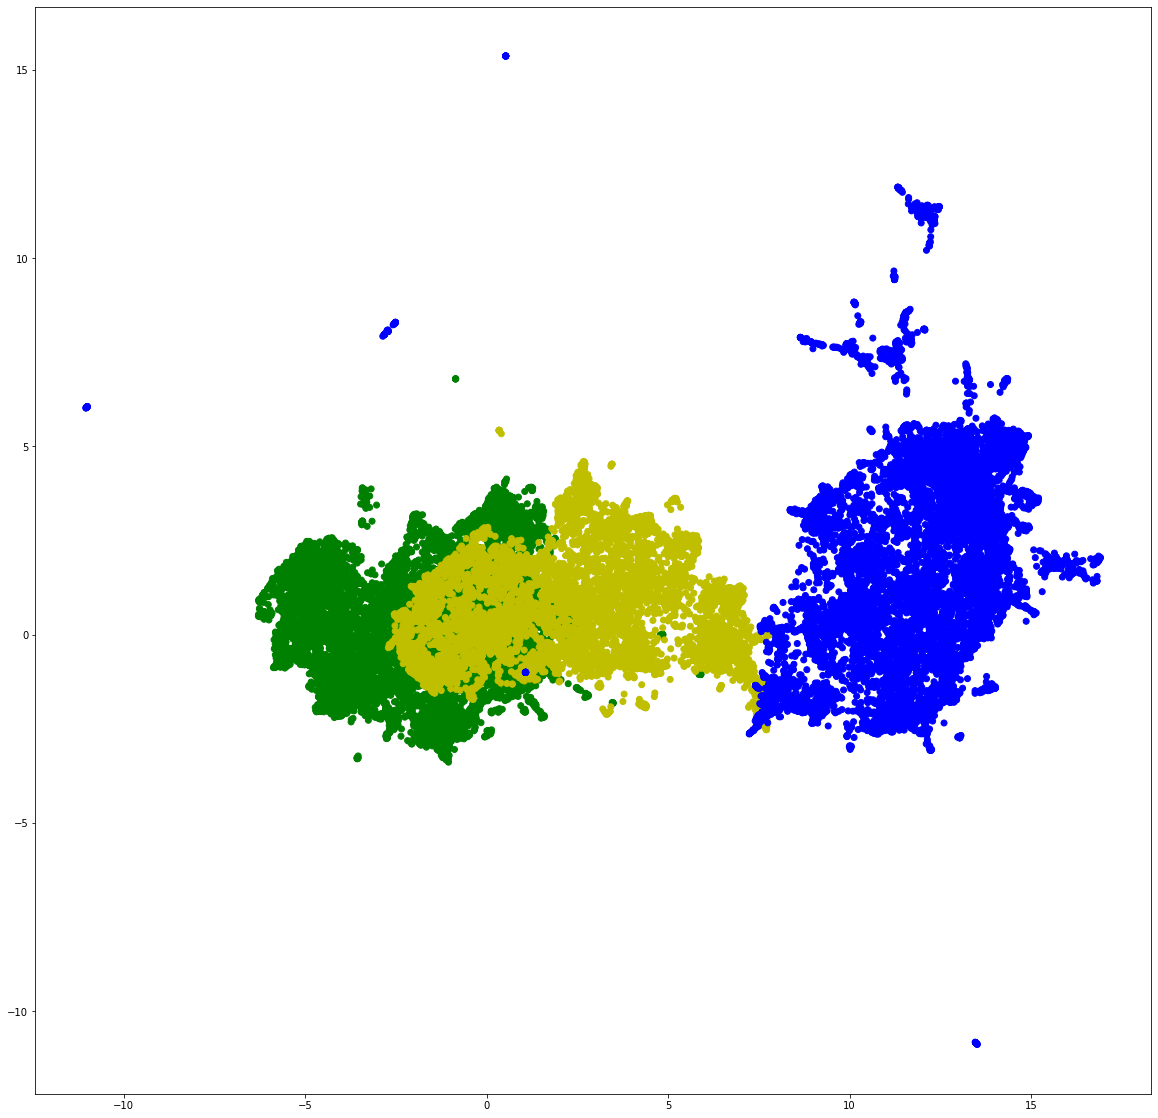

In [58]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_bio_2d[:,0]), y=list(all_corpora_bio_2d[:,1]), c=colors)

In [59]:
best_matches_bio = util.semantic_search(query_embeddings=corpus_embeddings_neg_otherexpr_bio, corpus_embeddings=corpus_embeddings_expr_pattern_bio)

In [60]:
[(i, corpus_id_score_dict) for i, values in enumerate(best_matches_bio) for corpus_id_score_dict in values if corpus_id_score_dict['score'] > 0.8 and corpus_id_score_dict['corpus_id'] != i][0:10]

[(59, {'corpus_id': 2145, 'score': 0.8702646493911743}),
 (59, {'corpus_id': 7782, 'score': 0.8626835346221924}),
 (59, {'corpus_id': 5220, 'score': 0.846471905708313}),
 (352, {'corpus_id': 2145, 'score': 0.9028753042221069}),
 (352, {'corpus_id': 7782, 'score': 0.8899054527282715}),
 (352, {'corpus_id': 5220, 'score': 0.8767735958099365}),
 (640, {'corpus_id': 2145, 'score': 0.8521284461021423}),
 (640, {'corpus_id': 7782, 'score': 0.8152115345001221}),
 (772, {'corpus_id': 2145, 'score': 0.8702431321144104}),
 (772, {'corpus_id': 7782, 'score': 0.8474069833755493})]

## Calculate centroids

In [61]:
centroid_exp_pattern_embeddings_bio = np.average(corpus_embeddings_expr_pattern_bio, 0)
centroid_subcellloc_embeddings_bio = np.average(corpus_embeddings_subcellloc_bio, 0)

## Classification accuracy

In [62]:
def get_stats(cosine_sim_thr, centroid_positive, embeddings_positive, embeddings_negative):
    tp = len([(i, c) for i in range(len(embeddings_positive)) if (c := (1 - spatial.distance.cosine(centroid_positive, embeddings_positive[i]))) > cosine_sim_thr and not all(embeddings_positive[i] == 0)])
    fn = len(embeddings_positive) - tp
    fp = len([(i, c) for i in range(len(embeddings_negative)) if (c := (1 - spatial.distance.cosine(centroid_positive, embeddings_negative[i]))) > cosine_sim_thr and not all(embeddings_negative[i] == 0)])
    tn = len(embeddings_negative) - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return f1, precision, recall, tpr, fpr

In [63]:
stats_expr_pattern_list = [get_stats(i, centroid_exp_pattern_embeddings_bio, corpus_embeddings_expr_pattern_bio, corpus_embeddings_neg_otherexpr_bio) for i in [elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)]]
stats_subcellloc_list = [get_stats(i, centroid_subcellloc_embeddings_bio, corpus_embeddings_subcellloc_bio, corpus_embeddings_neg_otherexpr_bio) for i in [elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)]]

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


## F1 measure analysis
### Expression Pattern

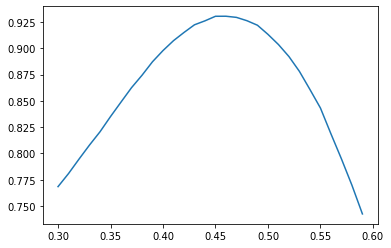

In [64]:
plt.plot([elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)], [stat[0] for stat in stats_expr_pattern_list])

### Subcellular localization

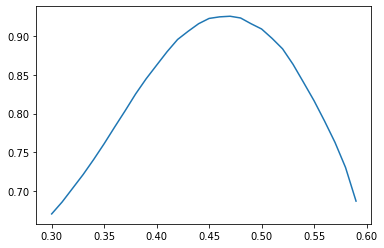

In [65]:
plt.plot([elem + 0.3 + i/100 for i, elem in enumerate([0] * 30)], [stat[0] for stat in stats_subcellloc_list])

## Precision and recall of best threshold
### Expression Pattern

In [66]:
print("Exp Pattern precision: " + str(get_stats(0.45, centroid_exp_pattern_embeddings_bio, corpus_embeddings_expr_pattern_bio, corpus_embeddings_neg_otherexpr_bio)[1]))
print("Exp pattern recall: " + str(get_stats(0.45, centroid_exp_pattern_embeddings_bio, corpus_embeddings_expr_pattern_bio, corpus_embeddings_neg_otherexpr_bio)[2]))

Exp Pattern precision: 0.9297264923138351
Exp pattern recall: 0.9314


### Subcellular localization

In [67]:
print("Subcellular localization precision: " + str(get_stats(0.45, centroid_subcellloc_embeddings_bio, corpus_embeddings_subcellloc_bio, corpus_embeddings_neg_otherexpr_bio)[1]))
print("Subcellular localization recall: " + str(get_stats(0.45, centroid_subcellloc_embeddings_bio, corpus_embeddings_subcellloc_bio, corpus_embeddings_neg_otherexpr_bio)[2]))

Subcellular localization precision: 0.9072164948453608
Subcellular localization recall: 0.938894277400582


## ROC
### Exp pattern

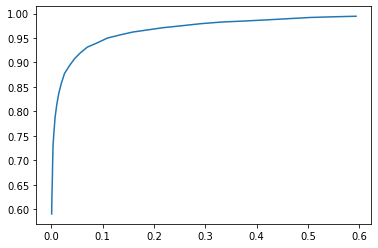

In [68]:
plt.plot([stat[4] for stat in stats_expr_pattern_list], [stat[3] for stat in stats_expr_pattern_list])

### Subcell localization

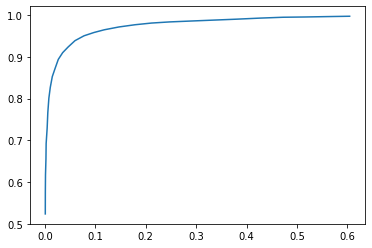

In [69]:
plt.plot([stat[4] for stat in stats_subcellloc_list], [stat[3] for stat in stats_subcellloc_list])

## Save centroids to file

In [70]:
savetxt("../sentence_embeddings/centroid_biosentvec_expr_pattern.csv", centroid_exp_pattern_embeddings_bio, delimiter=",")
savetxt("../sentence_embeddings/centroid_biosentvec_subcellloc.csv", centroid_subcellloc_embeddings_bio, delimiter=",")

## Prepare validation set

In [72]:
validation_nnc_high = read_sentences_from_file("../extracted_sentences/validation_nnc_high.txt", min_sent_length=min_sentence_length)
validation_nnc_med = read_sentences_from_file("../extracted_sentences/validation_nnc_med.txt", min_sent_length=min_sentence_length)
validation_nnc_low = read_sentences_from_file("../extracted_sentences/validation_nnc_low.txt", min_sent_length=min_sentence_length)
validation_nnc_neg = read_sentences_from_file("../extracted_sentences/validation_nnc_neg.txt", min_sent_length=min_sentence_length)
validation_all_clean = get_random_sentence_subset(clean_sentences([*validation_nnc_high, *validation_nnc_med, *validation_nnc_low, *validation_nnc_neg]), 1000)

In [73]:
validation_all_clean_embeddings = biosentvec_model.embed_sentences(validation_all_clean)

In [85]:
validation_all_clean_cosine_dist_exp_pattern = [1 - spatial.distance.cosine(centroid_exp_pattern_embeddings_bio, validation_all_clean_embeddings[i]) for i in range(len(validation_all_clean_embeddings))]
validation_all_clean_cosine_dist_subcellloc = [1 - spatial.distance.cosine(centroid_subcellloc_embeddings_bio, validation_all_clean_embeddings[i]) for i in range(len(validation_all_clean_embeddings))]

In [92]:
validation_set = [(validation_all_clean[i], validation_all_clean_cosine_dist_exp_pattern[i], validation_all_clean_cosine_dist_exp_pattern[i] > 0.45, validation_all_clean_cosine_dist_subcellloc[i], validation_all_clean_cosine_dist_subcellloc[i] > 0.45) for i in range(len(validation_all_clean))]

In [96]:
with open("../extracted_sentences/validation_set.csv", "w") as out_f_vs:
    out_f_vs.write("SENTENCE\tCOSINE_DISTANCE_EXP_PATTERN_CENTROID\tEXP_PATTERN_POSITIVE\tCOSINE_DISTANCE_SUBCELLLOC\tSUBCELLLOC_POSITIVE\n")
    for line in validation_set:
        out_f_vs.write("\t".join([str(col) for col in line]) + "\n")